In [93]:
"""
Dota2 Games Results Data Set
http://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results

Data Set:
http://archive.ics.uci.edu/ml/machine-learning-databases/00367/dota2Dataset.zip

Attribute Information:

Each row of the dataset is a single game with the following features (in the order in the vector):
1. Team won the game (1 or -1)
2. Cluster ID (related to location)
3. Game mode (eg All Pick)
4. Game type (eg. Ranked)
5 - end: Each element is an indicator for a hero. Value of 1 indicates that a player from team '1' played as that hero
   and '-1' for the other team. Hero can be selected by only one player each game. This means that each row has five
   '1' and five '-1' values.

"""

# This function that divides data into testing and training inspired by (1), page 49
import numpy as np
import pandas as pd


dotaData = pd.read_csv("dota2.csv")
dotaData = dotaData[:12500]

In [94]:
# Assign meaningful column names and mappings for win/lose
columns = ['team_won','cluster_id','game_mode','game_type']
heroNumber=1
for i in range(5,len(dotaData.columns)+1):
    columns.append("hero_"+str(heroNumber))
    heroNumber += 1
dotaData.columns = columns

winLoseMapping = {-1: 0}
replace_map = {'team_won': winLoseMapping }
dotaData = dotaData.replace(replace_map)

In [95]:
dotaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Columns: 117 entries, team_won to hero_113
dtypes: int64(117)
memory usage: 11.2 MB


In [96]:
corrMatrix = dotaData.corr()

corrMatrix["team_won"].sort_values(ascending=False)

team_won    1.000000
hero_57     0.057982
hero_9      0.054127
hero_67     0.049266
hero_36     0.045369
hero_5      0.043101
hero_103    0.040263
hero_32     0.037431
hero_75     0.034283
hero_6      0.031553
hero_42     0.031232
hero_84     0.030851
hero_28     0.030842
hero_22     0.029680
hero_102    0.028861
hero_70     0.027259
hero_44     0.023303
hero_14     0.023235
hero_48     0.022589
hero_18     0.022478
hero_96     0.021064
hero_87     0.018746
hero_29     0.017366
hero_37     0.016768
hero_68     0.015161
hero_83     0.015155
hero_20     0.015005
hero_27     0.014811
hero_51     0.014466
hero_4      0.013753
              ...   
hero_65    -0.020852
hero_113   -0.020862
hero_3     -0.021017
hero_69    -0.021712
hero_59    -0.021937
hero_46    -0.022385
hero_52    -0.024096
hero_7     -0.024723
hero_11    -0.025381
hero_86    -0.027983
hero_72    -0.028234
hero_80    -0.028625
hero_101   -0.028807
hero_26    -0.029124
hero_107   -0.031221
hero_112   -0.031312
hero_62    -0

In [97]:
from sklearn.model_selection import train_test_split

X = dotaData.drop('team_won',axis=1)
y = dotaData['team_won'].copy()

trainingData, testingData, trainingLabels, testingLabels = train_test_split(X, y, test_size=0.2, random_state=131)

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(trainingData, trainingLabels)

cross_val_score(knn, trainingData, trainingLabels, cv=10, n_jobs=-1, scoring="accuracy")

array([0.52, 0.53, 0.51, 0.52, 0.51, 0.52, 0.53, 0.53, 0.54, 0.52])

In [99]:
from sklearn.model_selection import cross_val_predict

trainingLabelPredictions = cross_val_predict(knn, trainingData, trainingLabels, cv=10, n_jobs=-1)

In [100]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(trainingLabels, trainingLabelPredictions)

In [101]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

print("label precision recall")
for label in range(2):
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

label precision recall
    0     0.492  0.465
    1     0.547  0.574


In [102]:
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Normalized confusion matrix


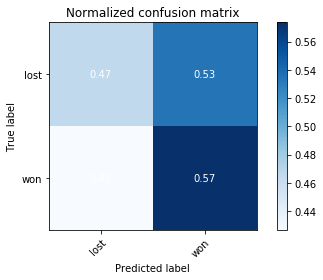

In [103]:
classes = np.array(('lost','won'))

plot_confusion_matrix(trainingLabels.to_numpy(), trainingLabelPredictions, normalize=True, classes=classes)

plt.show()

In [104]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(15,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [105]:
from sklearn.model_selection import validation_curve

def plot_model_complexity_curve(estimator, X, y, param_name, param_range, cv=None, n_jobs=None):
    # Calculate accuracy on training and test set using range of parameter values
    train_scores, test_scores = validation_curve(estimator, 
                                                 X, 
                                                 y, 
                                                 param_name=param_name, 
                                                 param_range=param_range,
                                                 cv=cv, 
                                                 scoring="accuracy", 
                                                 n_jobs=n_jobs)


    plt.figure(figsize=(15,5))
    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot mean accuracy scores for training and test sets
    plt.plot(param_range, train_mean, label="Training score", color="red")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="green")

    # Plot accurancy bands for training and test sets
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="red", alpha=0.1)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="green", alpha=0.1)

    # Create plot
    plt.title("Model Complexity")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc="best")
    
    print(train_mean)
    print(test_mean)

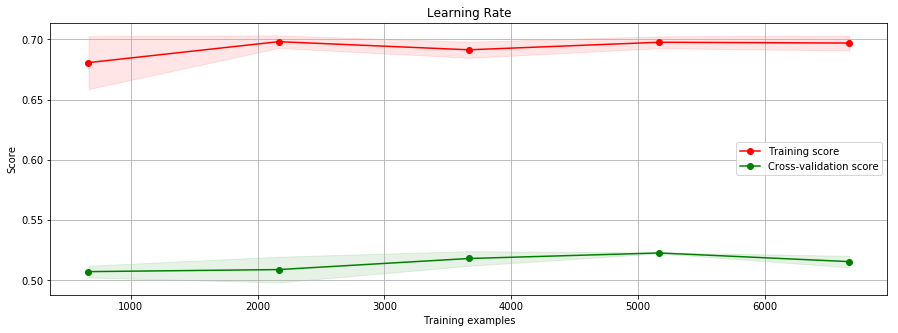

In [106]:
plot_learning_curve(knn,"Learning Rate", trainingData, trainingLabels,n_jobs=-1,cv=3)

plt.show()

[0.76 0.7  0.67 0.65 0.64 0.62 0.62 0.61 0.61]
[0.5  0.51 0.51 0.52 0.51 0.51 0.51 0.51 0.52]


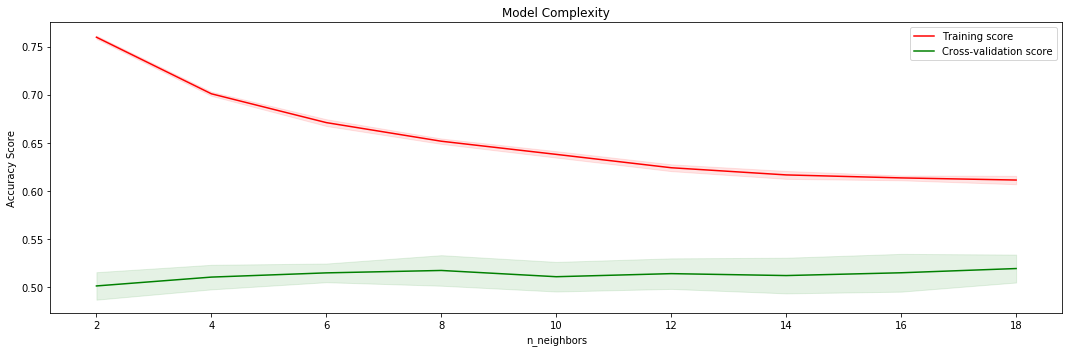

In [107]:
# K-NN Classifier

param_range = np.arange(2,20,2)

plot_model_complexity_curve(knn,trainingData, trainingLabels,'n_neighbors',param_range,cv=10,n_jobs=-1)
plt.savefig('dota_knn_complexity.pdf')
plt.show()

In [108]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(knn, {'n_neighbors': param_range, 'weights': ('distance', 'uniform')}, cv=10,n_jobs=-1)

In [109]:
clf.fit(trainingData, trainingLabels)
print(clf.best_score_)
print(clf.best_estimator_.n_neighbors)
print(clf.best_estimator_.weights)

0.5245
18
distance


In [110]:
## K-NN Prediction Performance
from sklearn.metrics import classification_report

predictions = clf.best_estimator_.predict(testingData)
print(classification_report(testingLabels, predictions))

              precision    recall  f1-score   support

           0       0.51      0.44      0.47      1171
           1       0.56      0.62      0.59      1329

    accuracy                           0.54      2500
   macro avg       0.53      0.53      0.53      2500
weighted avg       0.53      0.54      0.53      2500



Normalized confusion matrix


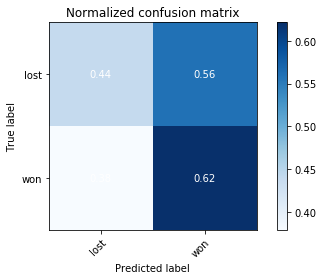

In [111]:
plot_confusion_matrix(testingLabels.to_numpy(), predictions, normalize=True, classes=classes)
plt.savefig('dota_knn_confusion_matrix.pdf')

plt.show()

[0.53 0.53 0.55 0.56 0.58 0.6  0.63 0.65 0.68 0.71 0.73 0.76 0.78 0.8
 0.83 0.85 0.86 0.88 0.9  0.91]
[0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.52 0.52 0.53 0.53 0.53
 0.53 0.53 0.53 0.53 0.52 0.52]


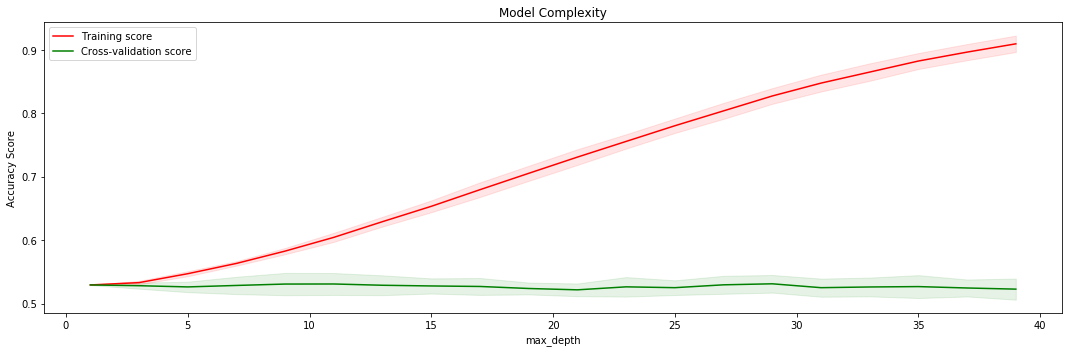

In [112]:
# DecisionTree Classification

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

param_range = np.arange(1,40,2)

plot_model_complexity_curve(dtc,trainingData, trainingLabels,'max_depth',param_range,cv=10,n_jobs=-1)
plt.savefig('dota_decisiontree_complexity.pdf')
plt.show()

In [113]:
clf = GridSearchCV(dtc, {'max_depth': param_range },cv=10,n_jobs=-1)
clf.fit(trainingData, trainingLabels)
print(clf.best_score_)
print(clf.best_estimator_.max_depth)

0.5319
29


In [114]:
## DecisionTree Prediction Performance

predictions = clf.best_estimator_.predict(testingData)
print(classification_report(testingLabels, predictions))

              precision    recall  f1-score   support

           0       0.50      0.54      0.52      1171
           1       0.57      0.53      0.55      1329

    accuracy                           0.53      2500
   macro avg       0.53      0.53      0.53      2500
weighted avg       0.54      0.53      0.53      2500



Normalized confusion matrix


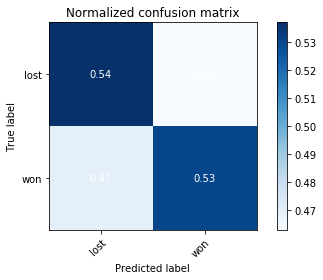

In [115]:
plot_confusion_matrix(testingLabels.to_numpy(), predictions, normalize=True, classes=classes)
plt.savefig('dota_decisiontree_confusion_matrix.pdf')

plt.show()

/home/rowjones/.local/lib64/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[0.59 0.57 0.58 0.58 0.59 0.6 ]
[0.57 0.56 0.56 0.56 0.57 0.56]


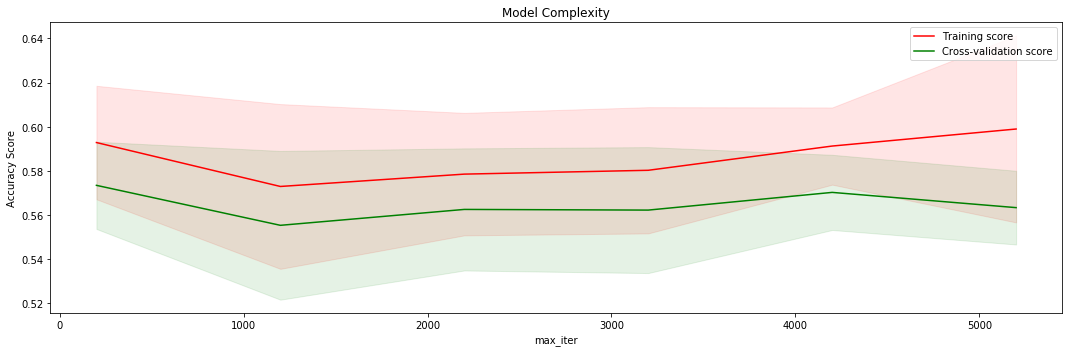

In [116]:
# Neural Network Classification

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
param_range = np.arange(200,5300,1000)
param_name = 'max_iter'

plot_model_complexity_curve(mlp,trainingData, trainingLabels,param_name,param_range,cv=10,n_jobs=-1)
plt.savefig('dota_nn_complexity.pdf')
plt.show()

In [119]:
param_range = np.arange(200,5300,1000)
clf = GridSearchCV(mlp, {'max_iter': param_range },cv=10,n_jobs=-1)
clf.fit(trainingData, trainingLabels)
print(clf.best_score_)
print(clf.best_estimator_.max_iter)

0.5757
3200


In [120]:
## Neural Network Prediction Performance

predictions = clf.best_estimator_.predict(testingData)
print(classification_report(testingLabels, predictions))

              precision    recall  f1-score   support

           0       0.53      0.71      0.61      1171
           1       0.64      0.45      0.53      1329

    accuracy                           0.57      2500
   macro avg       0.59      0.58      0.57      2500
weighted avg       0.59      0.57      0.57      2500



Normalized confusion matrix


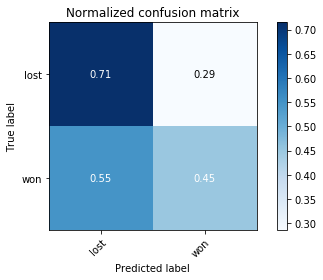

In [121]:
plot_confusion_matrix(testingLabels.to_numpy(), predictions, normalize=True, classes=classes)
plt.savefig('dota_nn_confusion_matrix.pdf')

plt.show()

[0.61 0.53 0.64]
[0.59 0.53 0.57]


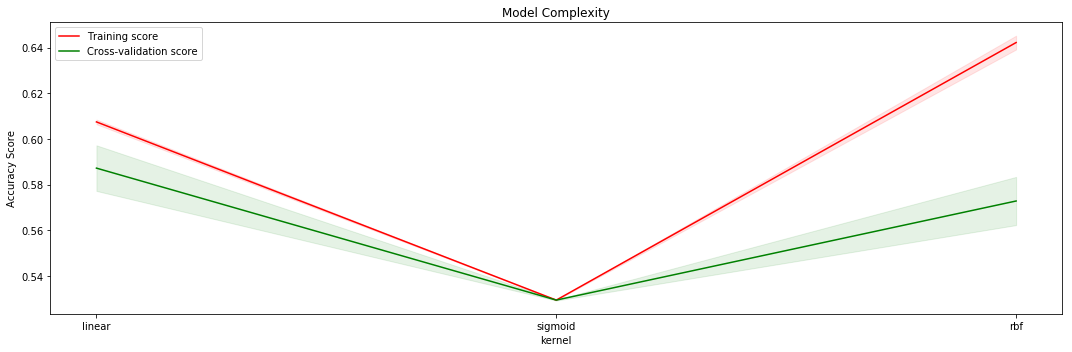

In [124]:
# Support Vector Machine Classification
from sklearn.svm import SVC
svc = SVC(gamma='auto')

param_range = [ 'linear', 'sigmoid', 'rbf' ]
param_name = 'kernel'

plot_model_complexity_curve(svc,trainingData, trainingLabels,param_name,param_range,cv=10,n_jobs=-1)
plt.savefig('dota_svm_complexity.pdf')
plt.show()

In [126]:
clf = GridSearchCV(svc, {'kernel': param_range },cv=10,n_jobs=-1)
clf.fit(trainingData, trainingLabels)
print(clf.best_score_)
print(clf.best_estimator_.kernel)

0.5872
linear


In [127]:
## Support Vector Machine Prediction Performance

predictions = clf.best_estimator_.predict(testingData)
print(classification_report(testingLabels, predictions))

              precision    recall  f1-score   support

           0       0.58      0.49      0.53      1171
           1       0.61      0.69      0.65      1329

    accuracy                           0.60      2500
   macro avg       0.60      0.59      0.59      2500
weighted avg       0.60      0.60      0.59      2500



Normalized confusion matrix


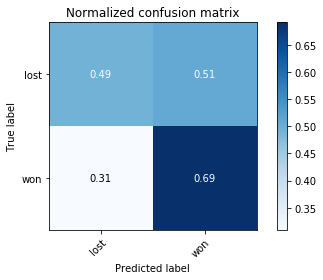

In [128]:
plot_confusion_matrix(testingLabels.to_numpy(), predictions, normalize=True, classes=classes)
plt.savefig('dota_svm_confusion_matrix.pdf')

plt.show()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.52 0.52 0.52 0.52 0.53 0.54 0.53 0.54 0.53 0.53 0.53 0.53 0.53 0.54
 0.54 0.54 0.53 0.54 0.53 0.54]


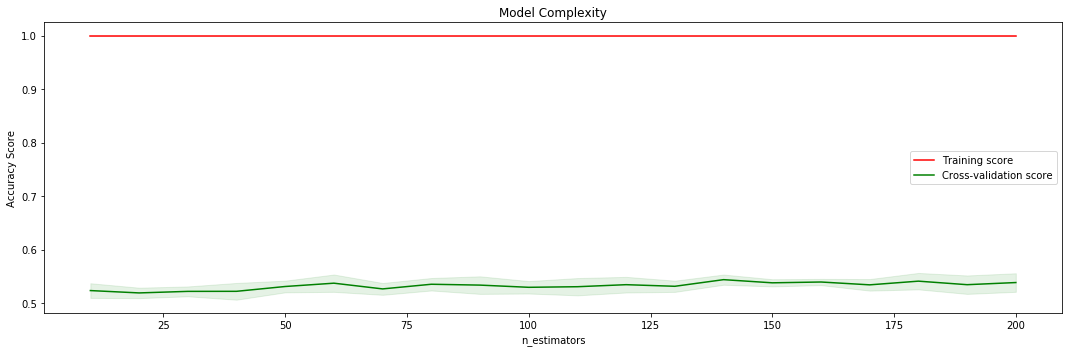

In [130]:
# Boosted Decision Tree Classification
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))

param_range = np.arange(10,210,10)
param_name = 'n_estimators'

plot_model_complexity_curve(abc,trainingData, trainingLabels,param_name,param_range,cv=10,n_jobs=-1)
plt.savefig('car_boosted_complexity.pdf')
plt.show()

In [131]:
clf = GridSearchCV(abc, {'n_estimators': param_range },cv=10,iid=True,n_jobs=-1)
clf.fit(trainingData, trainingLabels)
print(clf.best_score_)
print(clf.best_estimator_.n_estimators)

0.5418
90


In [132]:
## Boosted Decision Tree Prediction Performance

predictions = clf.best_estimator_.predict(testingData)
print(classification_report(testingLabels, predictions))

              precision    recall  f1-score   support

           0       0.50      0.47      0.49      1171
           1       0.56      0.59      0.57      1329

    accuracy                           0.53      2500
   macro avg       0.53      0.53      0.53      2500
weighted avg       0.53      0.53      0.53      2500



Normalized confusion matrix


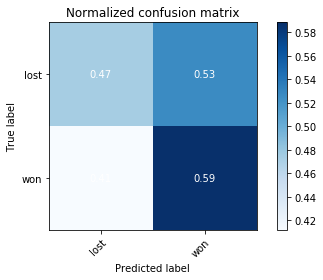

In [133]:
plot_confusion_matrix(testingLabels.to_numpy(), predictions, normalize=True, classes=classes)
plt.savefig('dota_boosted_confusion_matrix.pdf')

plt.show()